<a href="https://colab.research.google.com/github/MiguelOliveira1200874/ClothingRecomender/blob/main/ShopRecomender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from dateutil import parser

In [3]:
# Step 1: Load the data
df = pd.read_csv('/content/retail_data.csv')

In [4]:
# Step 2: Handle missing values
numeric_features = ['Transaction_ID', 'Customer_ID', 'Age', 'Total_Purchases', 'Amount', 'Total_Amount', 'Ratings']
categorical_features = ['Gender', 'Customer_Segment', 'Income', 'City', 'State', 'Country', 'Product_Category', 'Product_Brand', 'Product_Type', 'Shipping_Method', 'Payment_Method', 'Order_Status']

# Impute numeric features with median
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

# Impute categorical features with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

In [5]:
# Step 3: Encode categorical features
# Label Encoding for binary/ordinal categories
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Customer_Segment'] = le.fit_transform(df['Customer_Segment'])

# Ordinal Encoding for 'Income'
income_encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High']])
df['Income'] = income_encoder.fit_transform(df[['Income']])

# One-Hot Encoding for other categorical features
categorical_features_onehot = ['City', 'State', 'Country', 'Product_Category', 'Product_Brand', 'Product_Type', 'Shipping_Method', 'Payment_Method', 'Order_Status']
df_encoded = pd.get_dummies(df, columns=categorical_features_onehot)

In [6]:
def parse_mixed_dates(date_str):
    try:
        return parser.parse(date_str, dayfirst=False, yearfirst=False)
    except:
        return pd.NaT  # Return Not-a-Time for any unparseable dates

# Step 4: Process date and time features
df_encoded['Date'] = df_encoded['Date'].apply(parse_mixed_dates)
df_encoded['DayOfWeek'] = df_encoded['Date'].dt.dayofweek
df_encoded['IsWeekend'] = df_encoded['DayOfWeek'].isin([5, 6]).astype(int)
df_encoded['Month'] = df_encoded['Date'].dt.month
df_encoded['Season'] = pd.cut(df_encoded['Date'].dt.month, bins=[0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])
df_encoded['Hour'] = pd.to_datetime(df_encoded['Time']).dt.hour
df_encoded['TimeOfDay'] = pd.cut(df_encoded['Hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# One-hot encode new categorical features while preserving original columns
for column in ['DayOfWeek', 'Month', 'Season', 'TimeOfDay']:
    one_hot = pd.get_dummies(df_encoded[column], prefix=column)
    df_encoded = pd.concat([df_encoded, one_hot], axis=1)

# Print the first few rows of the date-related columns to verify
print(df_encoded[['Date', 'DayOfWeek', 'IsWeekend', 'Month', 'Season', 'Hour', 'TimeOfDay']].head())

# Print the names of all columns to verify the one-hot encoded columns
print("\nAll column names:")
print(df_encoded.columns.tolist())

<ipython-input-6-f481b7d7afe2>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_encoded['Hour'] = pd.to_datetime(df_encoded['Time']).dt.hour


        Date  DayOfWeek  IsWeekend  Month  Season  Hour  TimeOfDay
0 2023-09-18        0.0          0    9.0  Summer  22.0    Evening
1 2023-12-31        6.0          1   12.0    Fall   8.0    Morning
2 2023-04-26        2.0          0    4.0  Spring   4.0      Night
3 2023-05-08        0.0          0    5.0  Spring  14.0  Afternoon
4 2024-01-10        2.0          0    1.0  Winter  16.0  Afternoon

All column names:
['Transaction_ID', 'Customer_ID', 'Name', 'Email', 'Phone', 'Address', 'Zipcode', 'Age', 'Gender', 'Income', 'Customer_Segment', 'Date', 'Year', 'Month', 'Time', 'Total_Purchases', 'Amount', 'Total_Amount', 'Feedback', 'Ratings', 'products', 'City_Adelaide', 'City_Albuquerque', 'City_Albury-Wodonga', 'City_Arlington', 'City_Atlanta', 'City_Austin', 'City_Ballarat', 'City_Baltimore', 'City_Barrie', 'City_Belfast', 'City_Bendigo', 'City_Berlin', 'City_Bielefeld', 'City_Birmingham', 'City_Bochum', 'City_Bonn', 'City_Boston', 'City_Bremen', 'City_Brighton', 'City_Brisbane', 'C

In [7]:
# Step 5: Process text features (Feedback)
tfidf = TfidfVectorizer(max_features=100)  # Limit to top 100 features for simplicity
feedback_tfidf = tfidf.fit_transform(df_encoded['Feedback'].fillna(''))  # Fill NaN values
feedback_df = pd.DataFrame(feedback_tfidf.toarray(), columns=tfidf.get_feature_names_out())
df_encoded = pd.concat([df_encoded, feedback_df], axis=1)

In [8]:
# Step 6: Feature scaling
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])

In [9]:
# Step 7: Create target variable
df_encoded['ProductID'] = df_encoded['products'].astype('category').cat.codes

In [10]:
# Step 8: Additional feature engineering
# Customer Lifetime Value (simplified as total amount spent)
clv = df_encoded.groupby('Customer_ID')['Total_Amount'].sum().reset_index()
clv.columns = ['Customer_ID', 'CLV']
df_encoded = df_encoded.merge(clv, on='Customer_ID', how='left')

# Purchase Frequency (number of transactions per customer)
purchase_freq = df_encoded.groupby('Customer_ID').size().reset_index(name='PurchaseFrequency')
df_encoded = df_encoded.merge(purchase_freq, on='Customer_ID', how='left')

# Product Popularity Score
product_popularity = df_encoded.groupby('products').size().reset_index(name='PopularityScore')
df_encoded = df_encoded.merge(product_popularity, on='products', how='left')

In [11]:
# Step 9: Drop unnecessary columns
columns_to_drop = ['Name', 'Email', 'Phone', 'Address', 'Zipcode', 'Date', 'Year', 'Time', 'Feedback', 'products']
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Final step: Save the preprocessed data
df_encoded.to_csv('preprocessed_data.csv', index=False)

print("Data preprocessing completed. Preprocessed data saved as 'preprocessed_data.csv'")
print(f"Shape of preprocessed data: {df_encoded.shape}")
print("\nColumn names:")
print(df_encoded.columns.tolist())

Data preprocessing completed. Preprocessed data saved as 'preprocessed_data.csv'
Shape of preprocessed data: (122755, 301)

Column names:
['Transaction_ID', 'Customer_ID', 'Age', 'Gender', 'Income', 'Customer_Segment', 'Month', 'Total_Purchases', 'Amount', 'Total_Amount', 'Ratings', 'City_Adelaide', 'City_Albuquerque', 'City_Albury-Wodonga', 'City_Arlington', 'City_Atlanta', 'City_Austin', 'City_Ballarat', 'City_Baltimore', 'City_Barrie', 'City_Belfast', 'City_Bendigo', 'City_Berlin', 'City_Bielefeld', 'City_Birmingham', 'City_Bochum', 'City_Bonn', 'City_Boston', 'City_Bremen', 'City_Brighton', 'City_Brisbane', 'City_Bristol', 'City_Cairns', 'City_Calgary', 'City_Canberra', 'City_Cardiff', 'City_Charlotte', 'City_Chicago', 'City_Cleveland', 'City_Cologne', 'City_Colorado Springs', 'City_Columbus', 'City_Dallas', 'City_Darwin', 'City_Denver', 'City_Detroit', 'City_Dortmund', 'City_Dresden', 'City_Duisburg', 'City_Düsseldorf', 'City_Edinburgh', 'City_Edmonton', 'City_El Paso', 'City_Esse

In [12]:
# Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

In [13]:
# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

   Transaction_ID  Customer_ID       Age  Gender  Income  Customer_Segment  \
0        1.232692    -0.683980 -0.713252       1     0.0                 2   
1       -1.282432     0.566412 -0.892930       0     0.0                 1   
2        0.456128    -0.955488  1.712398       1     0.0                 2   
3        0.669491     0.272166  2.431109       1     2.0                 1   
4       -0.198349    -1.043631 -0.623413       1     0.0                 1   

   Month  Total_Purchases    Amount  Total_Amount  ...  TimeOfDay_Afternoon  \
0    9.0        -0.830176 -1.041923     -0.927177  ...                False   
1   12.0        -1.178797  1.050497     -0.500986  ...                False   
2    4.0        -0.830176  0.704202     -0.274279  ...                False   
3    5.0         0.564304  0.689536      0.965047  ...                 True   
4    1.0        -1.178797 -0.926805     -0.993879  ...                 True   

   TimeOfDay_Evening  average  bad  excellent  good  Pro

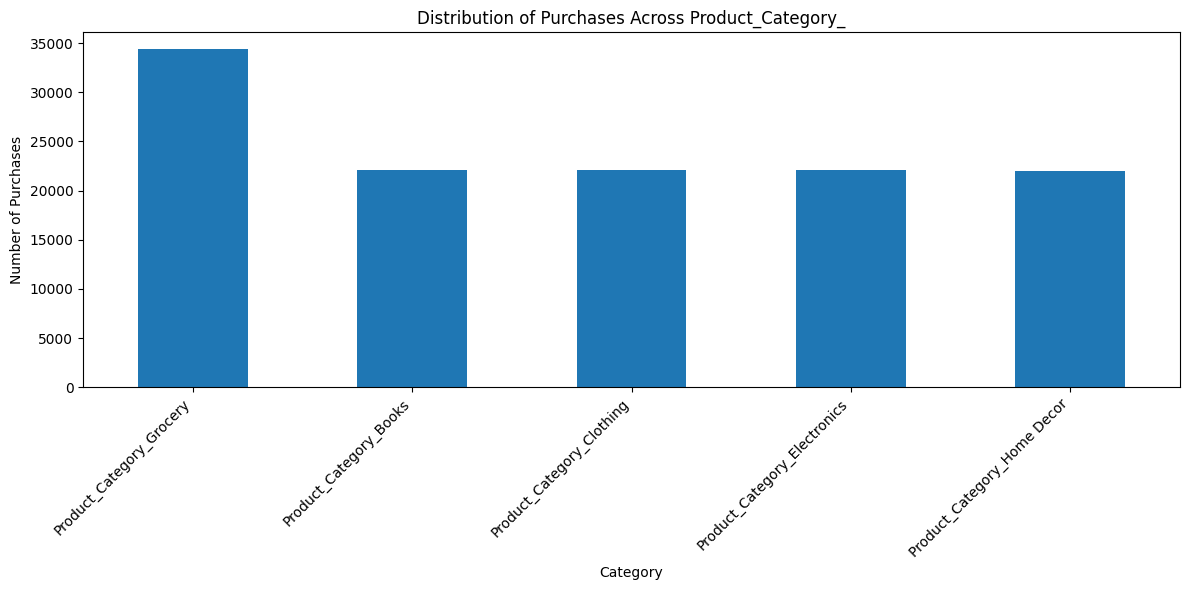

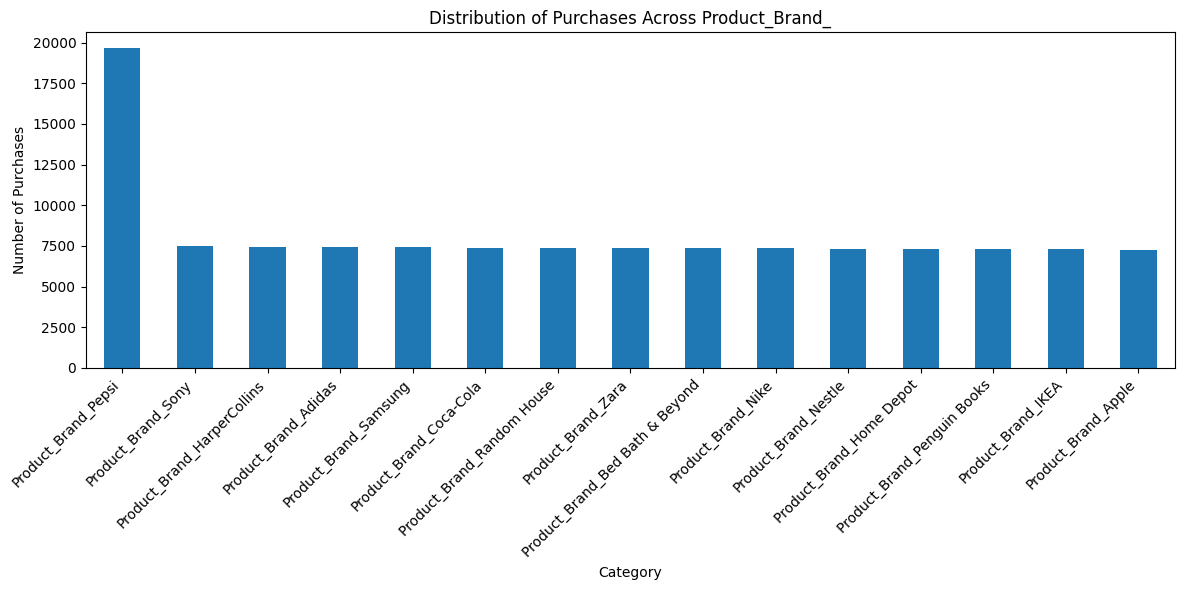

In [14]:
from matplotlib import pyplot as plt
# 1. Explore distribution of purchases across categories
def plot_category_distribution(df, column_prefix):
    category_columns = [col for col in df.columns if col.startswith(column_prefix)]
    category_totals = df[category_columns].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    category_totals.plot(kind='bar')
    plt.title(f'Distribution of Purchases Across {column_prefix}')
    plt.xlabel('Category')
    plt.ylabel('Number of Purchases')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_category_distribution(df, 'Product_Category_')
plot_category_distribution(df, 'Product_Brand_')

        Customer_ID  Total_Purchases  Total_Amount       Ratings
count  66877.000000     66877.000000  6.687700e+04  66877.000000
mean       0.000403        -0.001215 -1.893307e-16      0.001107
std        1.000789         0.833470  1.356235e+00      0.829181
min       -1.732309        -1.527417 -5.553710e+00     -1.542619
25%       -0.867768        -0.597763 -9.318236e-01     -0.817197
50%       -0.000804        -0.016729 -2.556384e-01     -0.091775
75%        0.868623         0.564304  8.045128e-01      0.633647
max        1.730239         1.610165  8.446289e+00      1.359070


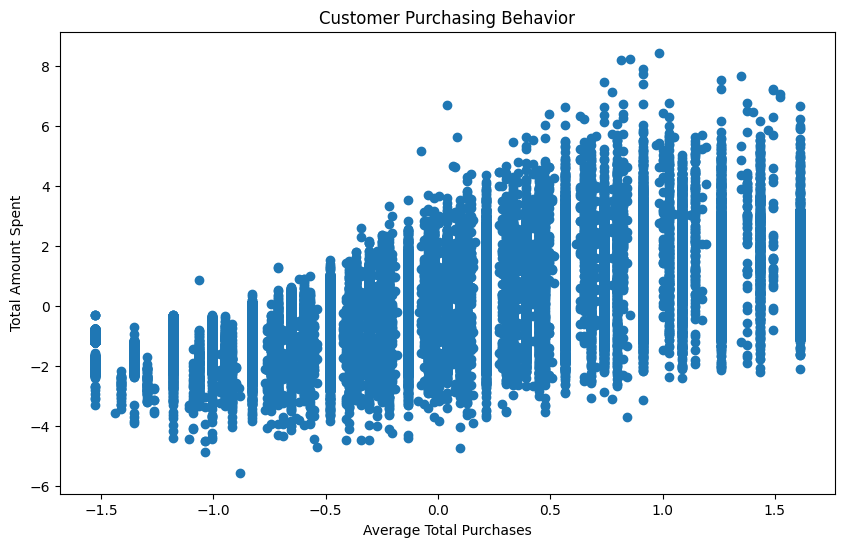

In [15]:
# 2. Analyze customer behavior
customer_analysis = df.groupby('Customer_ID').agg({
    'Total_Purchases': 'mean',
    'Total_Amount': 'sum',
    'Ratings': 'mean'
}).reset_index()

print(customer_analysis.describe())

plt.figure(figsize=(10, 6))
plt.scatter(customer_analysis['Total_Purchases'], customer_analysis['Total_Amount'])
plt.title('Customer Purchasing Behavior')
plt.xlabel('Average Total Purchases')
plt.ylabel('Total Amount Spent')
plt.show()

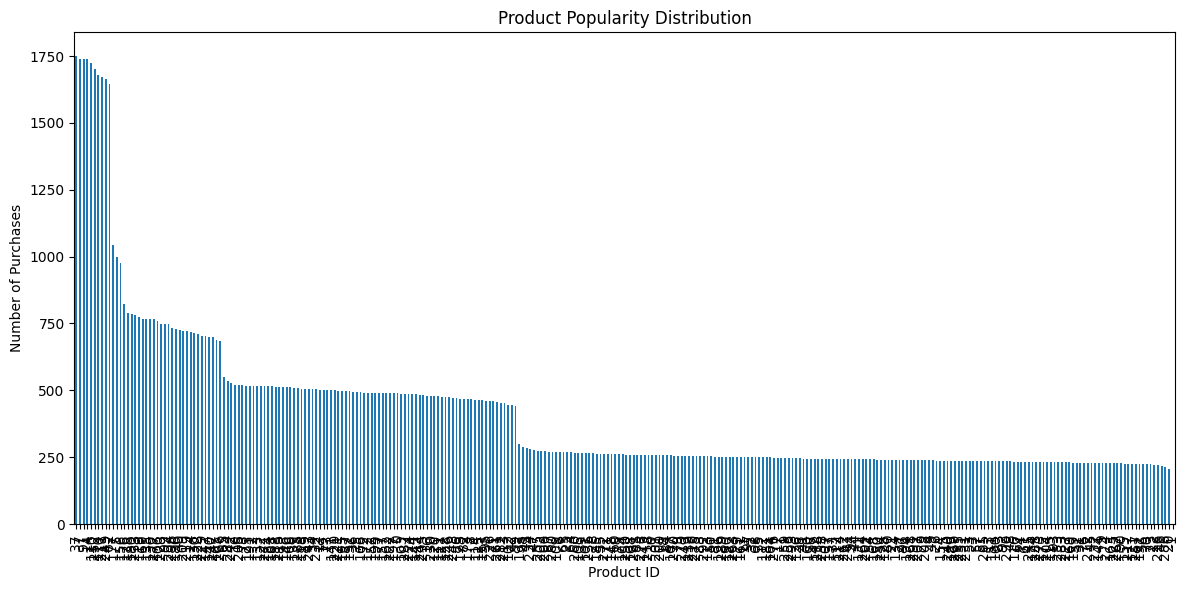

In [16]:
# 3. Check for data imbalance in product popularity
product_popularity = df['ProductID'].value_counts()
plt.figure(figsize=(12, 6))
product_popularity.plot(kind='bar')
plt.title('Product Popularity Distribution')
plt.xlabel('Product ID')
plt.ylabel('Number of Purchases')
plt.tight_layout()
plt.show()

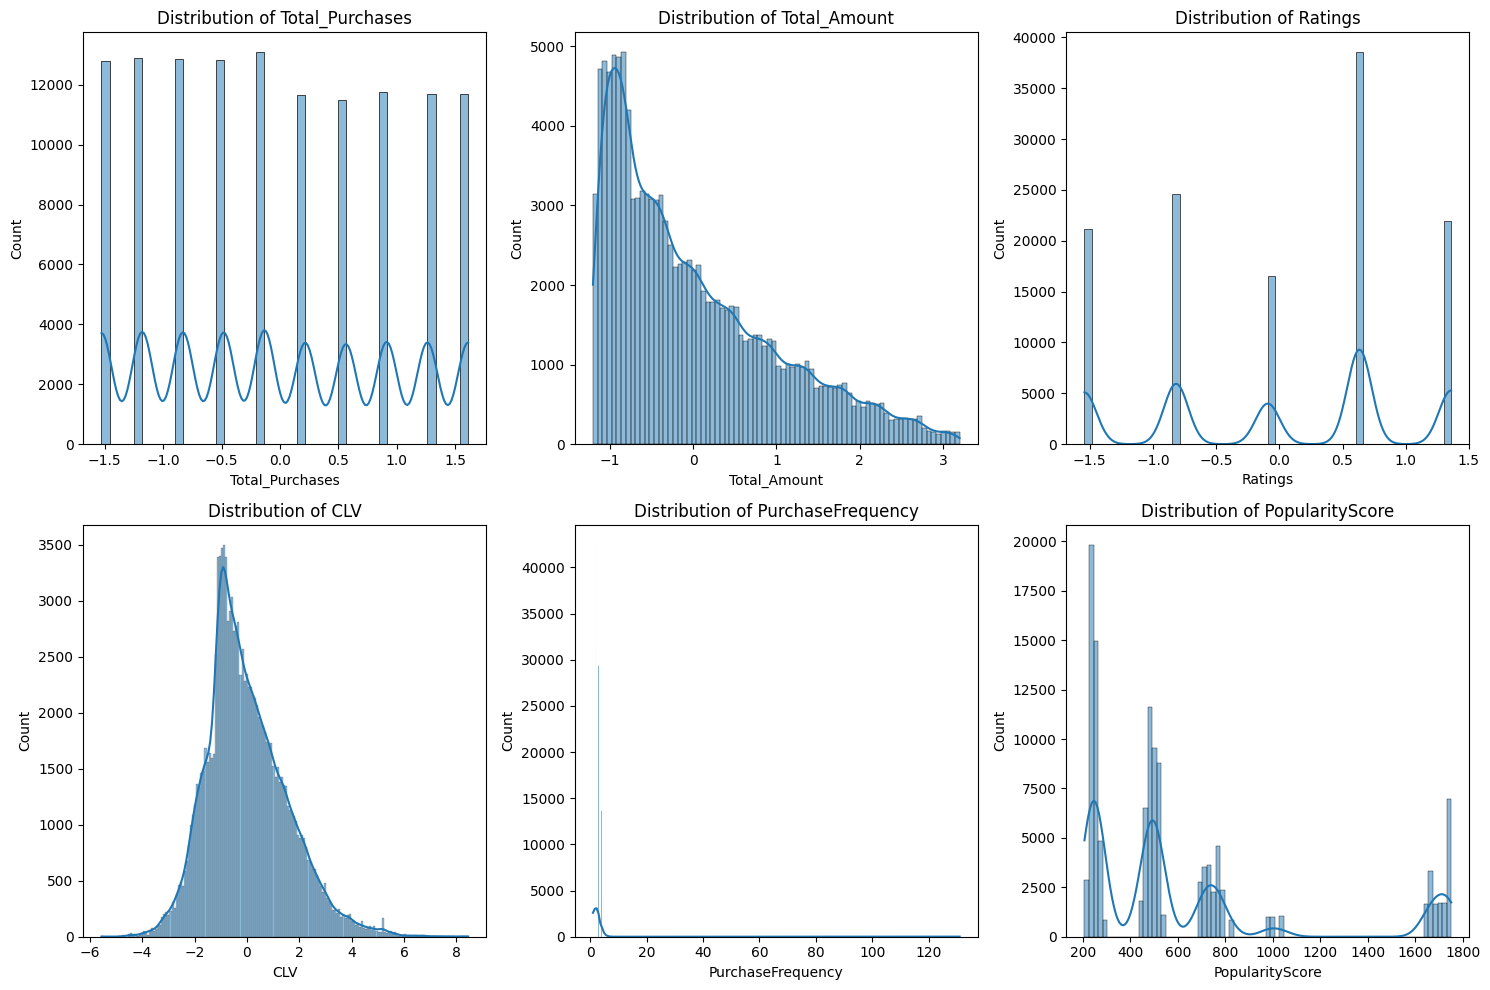

In [17]:

import seaborn as sns
# 4. Analyze key metrics
key_metrics = ['Total_Purchases', 'Total_Amount', 'Ratings', 'CLV', 'PurchaseFrequency', 'PopularityScore']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(key_metrics, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[metric], kde=True)
    plt.title(f'Distribution of {metric}')
    plt.xlabel(metric)
plt.tight_layout()
plt.show()

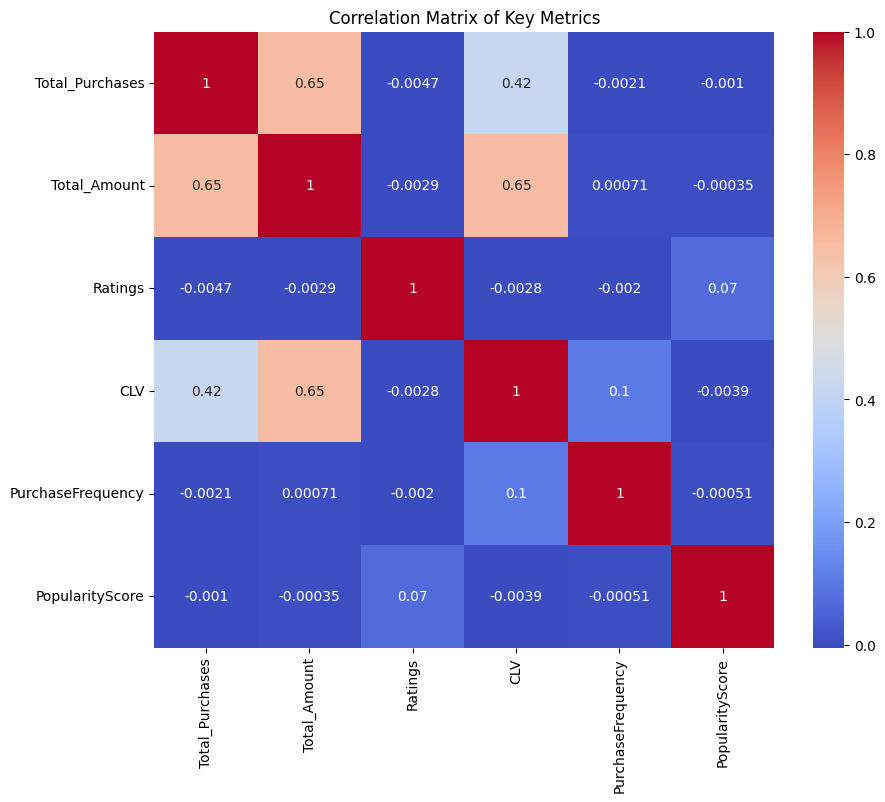

In [18]:
# 5. Correlation analysis
correlation_matrix = df[key_metrics].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Key Metrics')
plt.show()

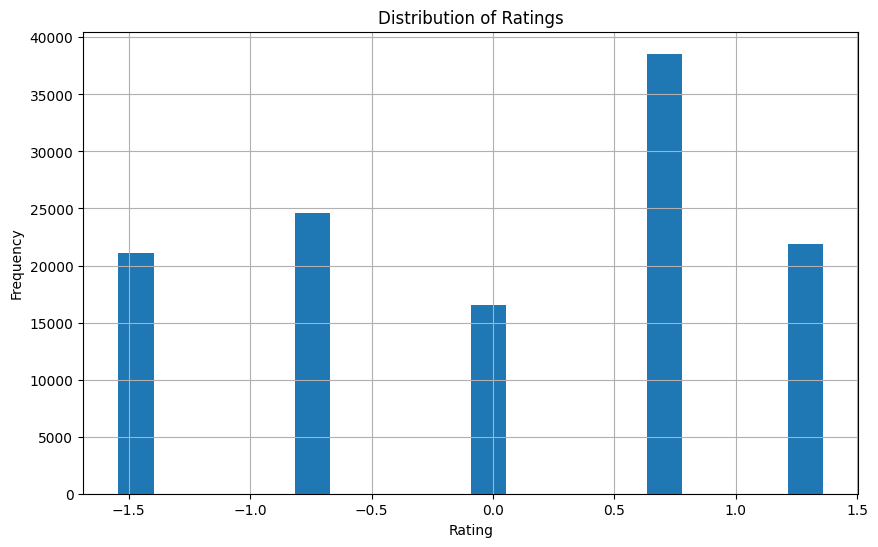

In [19]:
# 6. Analyze ratings distribution
plt.figure(figsize=(10, 6))
df['Ratings'].hist(bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [20]:
# 7. Time-based analysis
time_columns = ['Hour', 'IsWeekend'] + [col for col in df.columns if col.startswith(('DayOfWeek_', 'Month_', 'Season_', 'TimeOfDay_'))]
time_analysis = df.groupby(time_columns)['Total_Amount'].mean().reset_index()
print(time_analysis.sort_values('Total_Amount', ascending=False).head(10))


      Hour  IsWeekend  DayOfWeek_0.0  DayOfWeek_1.0  DayOfWeek_2.0  \
1530  18.0          0          False          False          False   
850   10.0          0          False          False          False   
425    5.0          0          False          False          False   
765    9.0          0          False          False          False   
1368  16.0          0          False          False          False   
513    6.0          0          False          False          False   
1645  19.0          0          False          False           True   
27     0.0          0          False          False           True   
1602  18.0          1          False          False          False   
1421  16.0          1          False          False          False   

      DayOfWeek_3.0  DayOfWeek_4.0  DayOfWeek_5.0  DayOfWeek_6.0  Month_1.0  \
1530          False          False          False          False      False   
850           False          False          False          False      F

In [21]:
# Print summary of findings
print("\nSummary of Findings:")
print(f"1. Most popular product category: {df.filter(like='Product_Category_').sum().idxmax()}")
print(f"2. Most popular brand: {df.filter(like='Product_Brand_').sum().idxmax()}")
print(f"3. Average customer rating: {df['Ratings'].mean():.2f}")
print(f"4. Average purchase frequency: {df['PurchaseFrequency'].mean():.2f}")
print(f"5. Average customer lifetime value: ${df['CLV'].mean():.2f}")
print(f"6. Most popular product (by ID): {df['ProductID'].mode().values[0]}")
print(f"7. Correlation between Total_Purchases and Total_Amount: {df['Total_Purchases'].corr(df['Total_Amount']):.2f}")


Summary of Findings:
1. Most popular product category: Product_Category_Grocery
2. Most popular brand: Product_Brand_Pepsi
3. Average customer rating: 0.00
4. Average purchase frequency: 2.50
5. Average customer lifetime value: $0.00
6. Most popular product (by ID): 37
7. Correlation between Total_Purchases and Total_Amount: 0.65


In [22]:
import cudf
import cupy as cp
import numpy as np
from cuml.neighbors import KNeighborsRegressor
from cuml.preprocessing import StandardScaler
from cuml.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the preprocessed data
df = cudf.read_csv('preprocessed_data.csv')

# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'ProductID' from features if it's present
if 'ProductID' in numeric_features:
    numeric_features.remove('ProductID')
if 'ProductID' in categorical_features:
    categorical_features.remove('ProductID')

# Separate features and target variable
X = df.drop(['ProductID'], axis=1)
y = df['ProductID']

# Handle categorical features
X = cudf.get_dummies(X, columns=categorical_features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to perform k-NN with cross-validation
def knn_cv(X, y, k_range, n_splits=5):
    cv_scores = []
    for k in k_range:
        mse_scores = []
        for i in range(n_splits):
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/n_splits, random_state=i)
            knn = KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_val)
            mse = mean_squared_error(y_val.to_array(), y_pred.to_array())
            mse_scores.append(mse)
        cv_scores.append(np.mean(mse_scores))
    return cv_scores

# Range of k values to try
k_range = range(1, 31)

# Perform cross-validation
cv_scores = knn_cv(X_train_scaled, y_train, k_range)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Cross-Validation Scores for Different k Values')
plt.show()

# Find the best k
best_k = k_range[np.argmin(cv_scores)]
print(f"Best k: {best_k}")

# Train the final model with the best k
best_knn = KNeighborsRegressor(n_neighbors=best_k)
best_knn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = best_knn.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test.to_array(), y_pred.to_array())
r2 = r2_score(y_test.to_array(), y_pred.to_array())

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test.to_array(), y_pred.to_array(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual ProductID')
plt.ylabel('Predicted ProductID')
plt.title('Actual vs Predicted ProductID')
plt.show()

ModuleNotFoundError: No module named 'cuml'

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


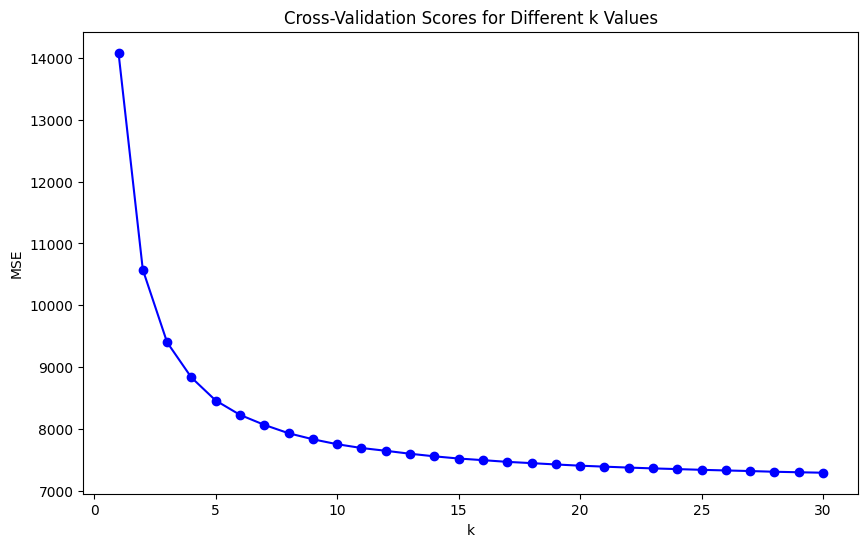

Best k: 30
Mean Squared Error: 7250.4840
R-squared Score: -0.0134


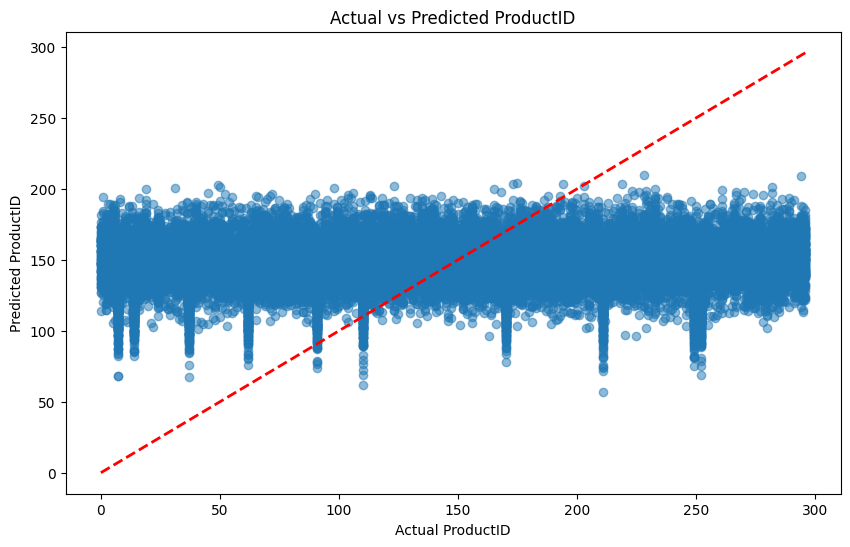

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'ProductID' from features if it's present
if 'ProductID' in numeric_features:
    numeric_features.remove('ProductID')
if 'ProductID' in categorical_features:
    categorical_features.remove('ProductID')

# Separate features and target variable
X = df.drop(['ProductID'], axis=1)
y = df['ProductID']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines preprocessing and k-NN
knn = KNeighborsRegressor()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', knn)
])

# Function to perform k-NN with cross-validation for a single k value
def knn_cv_single(k, pipeline, X, y):
    pipeline.set_params(knn__n_neighbors=k)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean()

# Function to perform k-NN with cross-validation for multiple k values in parallel
def knn_cv_parallel(pipeline, X, y, k_range):
    return Parallel(n_jobs=-1)(delayed(knn_cv_single)(k, pipeline, X, y) for k in k_range)

# Range of k values to try
k_range = range(1, 31)

# Perform cross-validation
cv_scores = knn_cv_parallel(pipeline, X_train, y_train, k_range)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('MSE')
plt.title('Cross-Validation Scores for Different k Values')
plt.show()

# Find the best k
best_k = k_range[np.argmin(cv_scores)]
print(f"Best k: {best_k}")

# Train the final model with the best k
pipeline.set_params(knn__n_neighbors=best_k)
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual ProductID')
plt.ylabel('Predicted ProductID')
plt.title('Actual vs Predicted ProductID')
plt.show()

Mean Squared Error: 7250.4840
Root Mean Squared Error: 85.1498
R-squared Score: -0.0134


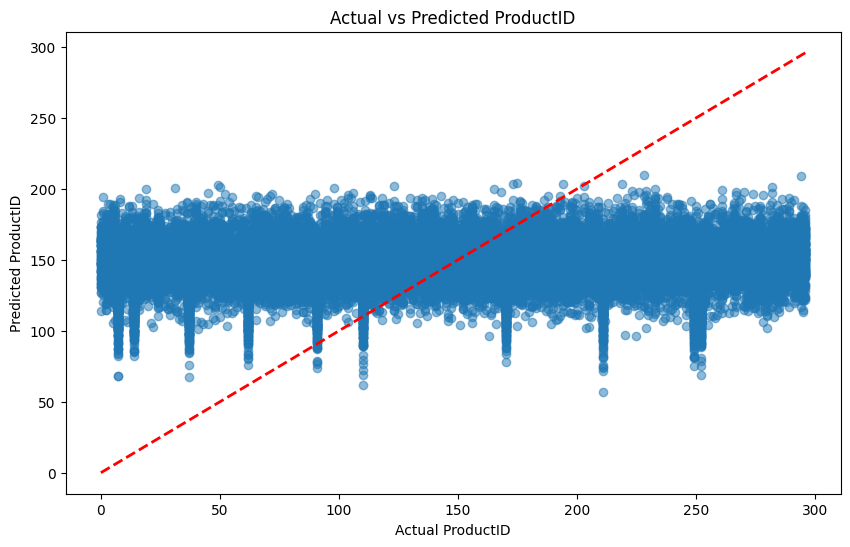

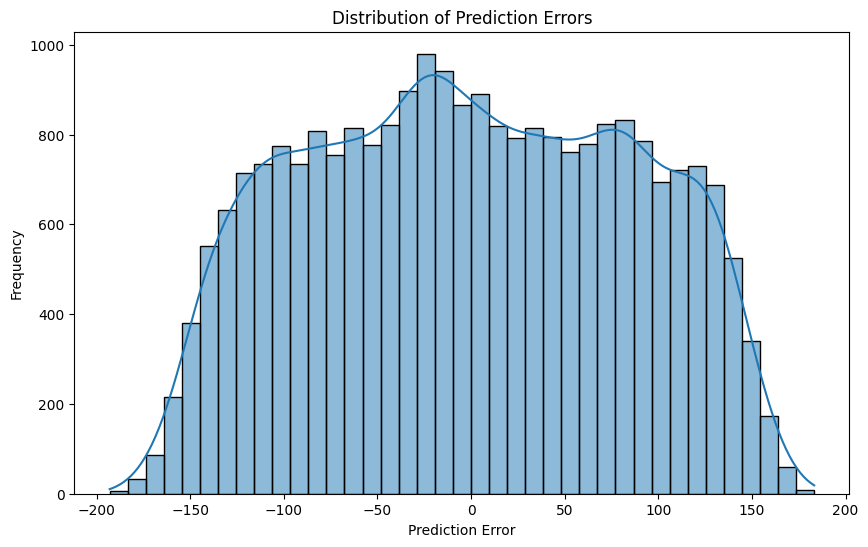


Top 10 largest prediction errors:
        Actual   Predicted  Difference
67348        1  194.066667  193.066667
95641        3  189.666667  186.666667
57191        4  189.633333  185.633333
39692        8  192.633333  184.633333
41118        5  188.766667  183.766667
38846        1  184.500000  183.500000
93758      252   68.766667  183.233333
40815        6  188.933333  182.933333
121818       8  190.566667  182.566667
24364        1  183.000000  182.000000


In [27]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create a dataframe with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Calculate the difference between actual and predicted
results_df['Difference'] = results_df['Actual'] - results_df['Predicted']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual ProductID')
plt.ylabel('Predicted ProductID')
plt.title('Actual vs Predicted ProductID')
plt.show()

# Plot histogram of prediction errors
plt.figure(figsize=(10, 6))
sns.histplot(results_df['Difference'], kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

# Identify the top 10 largest prediction errors
top_errors = results_df.abs().nlargest(10, 'Difference')
print("\nTop 10 largest prediction errors:")
print(top_errors)